In [1]:
import pandas as pd
import csv
import nltk
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
import keras
import tensorflow as tf
from keras import Input
from keras import optimizers
from keras import backend as K
import torch
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_blobs
from keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from itertools import chain
import seaborn as sns
from matplotlib import rcParams
from sklearn.model_selection import train_test_split

In [2]:
#OPEN DATA from pickle files
#x_train, x_test, y_train, y_test

with open('x_train.pkl', 'rb') as file:
    x_train = pickle.load(file)
    
with open('x_test.pkl', 'rb') as file:
    x_test = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('tweet_collection.pkl', 'rb') as file:
    tweet_collection = pickle.load(file)

In [3]:
print(len(x_train))

3584


In [4]:
#Convert Labels from Strings to categorical Integers {Non-Hate = 1, Hate = 0}

df_ytrain = pd.DataFrame(y_train, columns = ['Label'])
df_ytest = pd.DataFrame(y_test, columns = ['Label'])

#flatten training set for fitting on tfidf
x_train_fit = list(chain.from_iterable(x_train))

mapping = {'Non-hate': 0, 'Hate': 1}
df_ytrain = df_ytrain.replace({'Label': mapping})
df_ytest = df_ytest.replace({'Label': mapping})

train_y = df_ytrain['Label'].tolist()
test_y = df_ytest['Label'].tolist()

np_train_y = np.asarray(train_y)
np_test_y = np.asarray(test_y)

In [5]:
print(np_train_y.shape)

(3584,)


In [6]:
#Testing Encoding and Actual Values
for i in range(10):
    print("Sentence\n: "," ".join(str(item) for item in x_test[i]),"\n","True Value: ", y_test[i], "\nConverted: ",test_y[i],"\n~~~~~~~~~~~\n",sep="")

Sentence
: future president iktr gaga stans spitting facts
True Value: Non-hate
Converted: 0
~~~~~~~~~~~

Sentence
: tulungan nating manalo sara duterte darating eleksyon
True Value: Non-hate
Converted: 0
~~~~~~~~~~~

Sentence
: ayan spoon feed sau ha
True Value: Hate
Converted: 1
~~~~~~~~~~~

Sentence
: nagtataka okay lang suportahan communist group like npa tama gawain npa inyo parang tama tingin nyo yung pabahay kababayan natin sabagay wala pala kayo position kababayan natin okay lang syo ely
True Value: Hate
Converted: 1
~~~~~~~~~~~

Sentence
: obviously attend smni debate owner network sumobra naman po pagkaignorante try know search owner network benefit
True Value: Hate
Converted: 1
~~~~~~~~~~~

Sentence
: president satanas
True Value: Hate
Converted: 1
~~~~~~~~~~~

Sentence
: divorce easy option married couples would allowed philippines presidential candidate ferdinand said
True Value: Non-hate
Converted: 0
~~~~~~~~~~~

Sentence
: louder madam president
True Value: Non-hate
Conv

In [7]:
#TFIDF, classifer building using the training dataset of tweets using a maximum features of the top 40%

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

#classifier building/ fitting of training dataset to tfidf
fitted_training_x = tfidf.fit_transform(x_train)
fitted_testing_x = tfidf.transform(x_test)

#transform based on top 40 percent features
selector = SelectPercentile(f_classif, percentile = 40)
selector.fit(fitted_training_x, train_y)

SelectPercentile(percentile=40)

In [8]:
#Convert tweet tokens into vectors using the classifier built using tfidf

x_train_vectorized = selector.transform(fitted_training_x).toarray()
x_test_vectorized = selector.transform(fitted_testing_x).toarray()

number_of_features = len(x_train_vectorized[0])
print(number_of_features)

4222


In [9]:
#FFNN MODEL
print("training CNN ...")

#create model
model = Sequential()
model.add(Input(shape=(number_of_features,), name='Input-Layer'))
model.add(Dense(1000, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

#optimizer using the default values
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

#compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              4223000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                25050     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 2) 

In [10]:
#fit dataset and model
##### Step 5 - Fit keras model on the dataset
model_history = model.fit(x_train_vectorized, # input data
          np_train_y, # target data
          epochs=5, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
          verbose='auto',
          validation_split = 0.1
         )

model.save('cabasag_model.h5')

Epoch 1/5
101/101 [==============================] - 3s 21ms/step - loss: 0.5027 - accuracy: 0.7442 - val_loss: 0.3580 - val_accuracy: 0.8552
Epoch 2/5
101/101 [==============================] - 2s 18ms/step - loss: 0.2162 - accuracy: 0.9144 - val_loss: 0.3126 - val_accuracy: 0.8747
Epoch 3/5
101/101 [==============================] - 2s 18ms/step - loss: 0.1168 - accuracy: 0.9563 - val_loss: 0.3505 - val_accuracy: 0.8747
Epoch 4/5
101/101 [==============================] - 2s 18ms/step - loss: 0.0756 - accuracy: 0.9730 - val_loss: 0.3983 - val_accuracy: 0.8691
Epoch 5/5
101/101 [==============================] - 2s 20ms/step - loss: 0.0606 - accuracy: 0.9771 - val_loss: 0.4261 - val_accuracy: 0.8774


In [11]:
#test for accuracies

results_training = model.evaluate(x_train_vectorized, np_train_y)
print(results_training)

112/112 [==============================] - 1s 5ms/step - loss: 0.0749 - accuracy: 0.9724
[0.07491610199213028, 0.9723772406578064]


In [12]:
#test for accuracies

results_testing = model.evaluate(x_test_vectorized, np_test_y)
print(results_testing)

48/48 [==============================] - 0s 5ms/step - loss: 0.8155 - accuracy: 0.8008
[0.8155437111854553, 0.80078125]


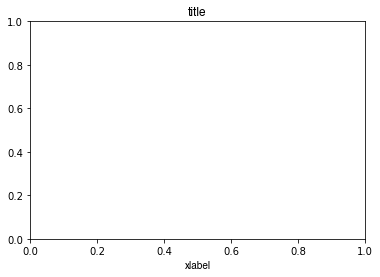

In [13]:
#plot configuration
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Blue, CB91_Amber]

csfont = {'fontname':'Helvetica'}
hfont = {'fontname':'Helvetica'}

plt.title('title',**csfont)
plt.xlabel('xlabel', **hfont)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

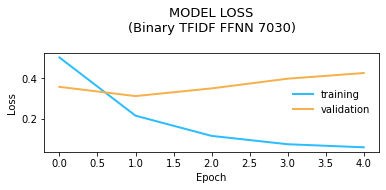

In [14]:
# plot loss during training
plt.subplot(212)
plt.title('MODEL LOSS\n(Binary TFIDF FFNN 7030)\n', fontsize = 13)
plt.plot(model_history.history['loss'], label='training', linewidth=2)
plt.plot(model_history.history['val_loss'], label='validation', linewidth=2)
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

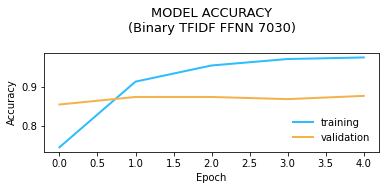

In [15]:
# plot accuracy during training
plt.subplot(212)
plt.title('MODEL ACCURACY\n(Binary TFIDF FFNN 7030)\n', fontsize = 13)
plt.plot(model_history.history['accuracy'], label='training', linewidth=2)
plt.plot(model_history.history['val_accuracy'], label='validation', linewidth=2)
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [16]:
#use predictions on test data
##### Step 6 - Use model to make predictions
# Predict class labels on training data
#pred_labels_train = (model.predict(x_train_vectorized) > 0.5).astype(int)
pred_labels_train = model.predict(x_train_vectorized)
# Predict class labels on a test data
#pred_labels_test = (model.predict(x_test_vectorized) > 0.5).astype(int)
pred_labels_test = model.predict(x_test_vectorized)

pred_labels_train_1 = []

pred_labels_test_1 = []

pred_labels_test_y = []

for i in range(len(pred_labels_train)):
    label = np.argmax(pred_labels_train[i])
    pred_labels_train_1.append(label)
    
for i in range(len(pred_labels_test)):
    label = np.argmax(pred_labels_test[i]) 
    pred_labels_test_1.append(label)
    pred_labels_test_y.append(pred_labels_test[i][label])
    
##### Step 7 - Model Performance Summary
print("")
print('-------------------- Model Summary --------------------\n')
model.summary() # print model summary
print("")
print('\n---------- Evaluation on Training Data ----------')
print(classification_report(np_train_y, pred_labels_train_1, digits=4))
print("")

print('\n---------- Evaluation on Test Data ----------')
print(classification_report(np_test_y, pred_labels_test_1, digits=4))
print("")

48/48 [==============================] - 0s 6ms/step

-------------------- Model Summary --------------------

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              4223000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                25050     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
           

[[603 175]
 [131 627]]


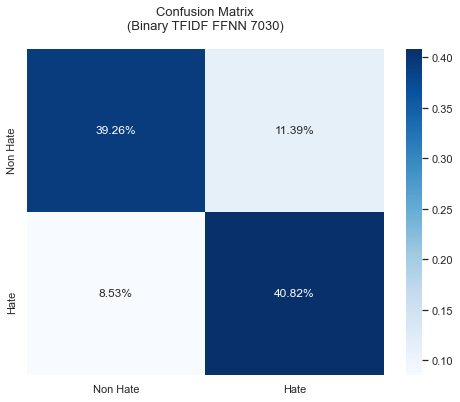

In [17]:
cf_matrix = confusion_matrix(np_test_y, pred_labels_test_1)
print(cf_matrix)
sns.set(rc={"figure.figsize":(8, 6)})
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels = ['Non Hate', 'Hate'], yticklabels = ['Non Hate', 'Hate'],
            fmt='.2%', cmap='Blues')

plt.title('Confusion Matrix\n(Binary TFIDF FFNN 7030)\n', fontsize = 13) # title with fontsize 20
plt.show()

In [18]:
test_results = pd.DataFrame(list(zip(x_test,pred_labels_test_1, pred_labels_test_y)), columns = ['Tweet','Prediction', 'Prediction Value'])
test_results 

,Tweet,Prediction,Prediction Value
0,"[future, president, iktr, gaga, stans, spittin...",0,0.953089
1,"[tulungan, nating, manalo, sara, duterte, dara...",0,0.999718
2,"[ayan, spoon, feed, sau, ha]",1,0.997534
3,"[nagtataka, okay, lang, suportahan, communist,...",1,0.999990
4,"[obviously, attend, smni, debate, owner, netwo...",0,0.985766
...,...,...,...
1531,"[makakalimutan, itong, h2h, grand, rally, napu...",0,0.999829
1532,"[daughters, girls, anong, klaseng, katangahan,...",1,0.999839
1533,"[even, signature, figure, liberal, party, proj...",1,0.933070
1534,"[best, job, woman]",0,0.999997


In [19]:
#Saving labels to be used on other files
true_labels = open('true_labels.pkl', 'wb')
pickle.dump(np_test_y,true_labels)
true_labels.close()

predicted_labels = open('TFIDFFFNN_predicted_labels.pkl', 'wb')
pickle.dump(pred_labels_test_1,predicted_labels)
predicted_labels.close()

TFIDFFFNN_test_results = open('TFIDFFFNN_test_results.pkl', 'wb')
pickle.dump(test_results,TFIDFFFNN_test_results)
TFIDFFFNN_test_results.close()

In [ ]:
#test_predictions = (model.predict(x_test_vectorized) > 0.5).astype(int)

#test_prediction_labels = []

#for i in range(len(test_predictions)):
    
#    trueval = 'Non-hate'
    
#    if(test_y[i] == 1):
 #       trueval = 'Hate'
        
#    pred = 'Non-hate'
    
 #   if(test_predictions[i][1] == 1):
 #       pred = 'Hate'
    
  #  test_prediction_labels.append(pred)
  #  print("Sentence\n: "," ".join(str(item) for item in x_test[i]),"\n","True Value: ", trueval, "\nPred: ",pred, "\n~~~~~~~~~~~\n",sep="")

In [ ]:
#comparison_dataframe = pd.DataFrame(list(zip(x_test,y_test, test_prediction_labels)), columns = ['Tweet','True Label', 'Clasiification Label'])  

#with pd.option_context('display.max_rows', None,
#                       'display.max_columns', None,
 #                      'display.precision', 3,
  #                     ):
 #   display(comparison_dataframe)